#### Imports

In [93]:
import glob
import random

import numpy as np
import pandas as pd
from pandas.core.groupby import DataFrameGroupBy
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from numpy import ndarray
from pandas import DataFrame
from matplotlib import pyplot as plt
import networkx as nx
from scipy.spatial import distance as distance_calculator
import torch
from torch.nn import Linear
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.utils import scatter
import seaborn as sn

#### Load data

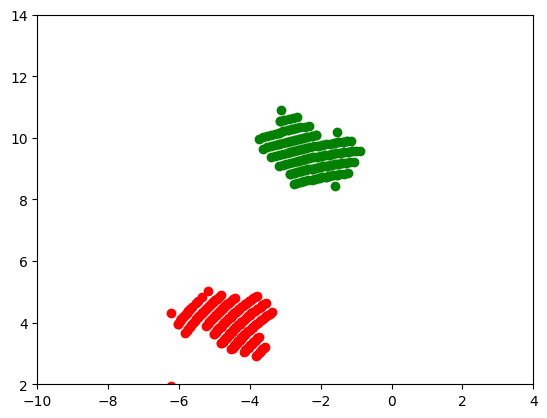

In [2]:
same_frame_2: DataFrame = pd.read_csv("data/2/2/Text_01Jun144751.csv104247.0.csv", header=None, dtype=float)
same_frame_3: DataFrame = pd.read_csv("data/3/3/Text_05Jun144421.csv104247.0.csv", header=None, dtype=float)

plt.scatter(same_frame_2.to_numpy()[:, 5], same_frame_2.to_numpy()[:, 4], c="red")
plt.scatter(same_frame_3.to_numpy()[:, 5], same_frame_3.to_numpy()[:, 4], c="green")
plt.xlim(-10, 4)
plt.ylim(2, 14)
plt.show()

In [3]:
random.seed(42)

features0: DataFrame = pd.concat(
    [pd.read_csv(filename, header=None, dtype=float) for filename in glob.glob("data/0/0/*.csv")])
features0.insert(8, "Label", np.zeros(len(features0)), True)
max_frame1 = max(features0[6])

features1: DataFrame = pd.concat(
    [pd.read_csv(filename, header=None, dtype=float) for filename in glob.glob("data/1/1/*.csv")])
features1.insert(8, "Label", np.ones(len(features1)), True)
min_frame = min(features1[6])
shift = max_frame1+10
features1[6] += shift
max_frame = max(features1[6])

features2: DataFrame = pd.concat(
    [pd.read_csv(filename, header=None, dtype=float) for filename in glob.glob("data/2/2/*.csv")])
features2.insert(8, "Label", np.full(len(features2), 2), True)
min_frame = min(features2[6])
shift = max_frame-min_frame+10
features2[6] += shift
max_frame = max(features2[6])

features3: DataFrame = pd.concat(
    [pd.read_csv(filename, header=None, dtype=float) for filename in glob.glob("data/3/3/*.csv")])
features3.insert(8, "Label", np.full(len(features3), 3), True)
min_frame = min(features3[6])
shift = max_frame-min_frame+10
features3[6] += shift
max_frame = max(features3[6])

features4: DataFrame = pd.concat(
    [pd.read_csv(filename, header=None, dtype=float) for filename in glob.glob("data/4/4/*.csv")])
features4.insert(8, "Label", np.full(len(features4), 4), True)
min_frame = min(features4[6])
shift = max_frame-min_frame+10
features4[6] += shift
max_frame = max(features4[6])

features5: DataFrame = pd.concat(
    [pd.read_csv(filename, header=None, dtype=float) for filename in glob.glob("data/bigger/bigger/*.csv")])
features5.insert(8, "Label", np.full(len(features5), 5), True)
min_frame = min(features5[6])
shift = max_frame-min_frame+10
features5[6] += shift

all_data = pd.concat([features0, features1, features2, features3, features4, features5])

all_data_grouped = all_data.groupby(6)
print(len(all_data_grouped))


22209


5.0
5.0
5.0


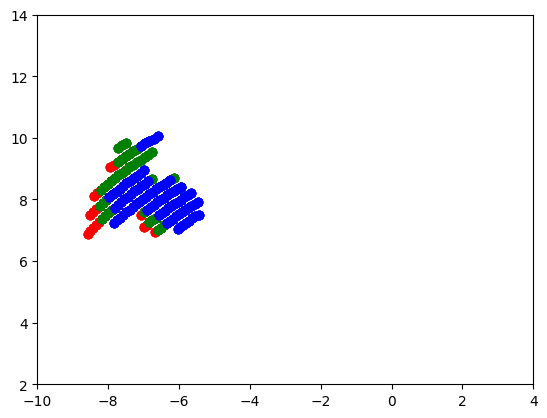

In [4]:
data = [frame.to_numpy() for (_, frame) in all_data_grouped]
frame_num = 21202
frame1 = data[frame_num]
frame2 = data[frame_num+1]
frame3 = data[frame_num+2]
print(frame1[0, 8])
print(frame2[0, 8])
print(frame3[0, 8])
plt.scatter(frame1[:, 5], frame1[:, 4], c="red")
plt.scatter(frame2[:, 5], frame2[:, 4], c="green")
plt.scatter(frame3[:, 5], frame3[:, 4], c="blue")
plt.xlim(-10, 4)
plt.ylim(2, 14)
plt.show()

#### Split the data

In [5]:
#TODO: make function that keeps consequent frames together depending of frame_depth
#TODO: do not split here but split the torch dataset

shuffled = np.asarray([frame for (_, frame) in all_data_grouped], dtype="object")
# random.shuffle(shuffled)
# train, test, val = np.split(shuffled, [int(0.7 * len(shuffled)), int(0.85 * len(shuffled))], axis=0)
# 
# # Split the train, test and validation sets to features and labels
# X_train = [df.drop([7,'Label'], axis=1) for df in train]
# Y_train = [df['Label'] for df in train]
# 
# X_test = [df.drop([7,'Label'], axis=1) for df in test]
# Y_test = [df['Label'] for df in test]
# 
# X_val = [df.drop([7,'Label'], axis=1) for df in val]
# Y_val = [df['Label'] for df in val]

In [114]:
class Graph:
    def __init__(self, nodes, edges, adjacency_list, global_attr, label):
        self.nodes = nodes
        self.edges = edges
        self.adjacency_list = adjacency_list
        self.global_attr = global_attr
        self.label = label

    @staticmethod
    def nearest_neighbours(point, previous_frame):
        distances = []
        for p in previous_frame:
            distances.append(np.linalg.norm(point-p))
        return np.asarray(distances)

    @staticmethod
    def connect_frames(current_frame, previous_frame, k: int, start_index: int):
        edges = []
        adjacency_list = []
        previous_nodes = np.arange(len(previous_frame))
        for i, point in enumerate(current_frame):
            # distances = Graph.nearest_neighbours(point, previous_frame)
            distances = distance_calculator.cdist([point], previous_frame, 'euclidean')[0]
            idx = distances.argsort()[::-1]
            distances = distances[idx]
            previous_nodes = previous_nodes[idx]
            for j in range(k):
                edges.append(distances[j])
                adjacency_list.append((i+start_index, previous_nodes[j]+start_index+len(current_frame)))
        return edges, adjacency_list

    @staticmethod
    def create_graph_list(frames:[DataFrame], k = 1, frame_depth = 2):
        graphs = []
        for i, frame in enumerate(frames[frame_depth:]):
            nodes = []
            edges = []
            adjacency_list = []
            relevant_frames = frames[i: i + frame_depth + 1]
            point_data = [rf.drop([0,1,6,7, "Label"], axis=1) for rf in relevant_frames]
            time_distance = relevant_frames[-1].iloc[0, 6] - relevant_frames[0].iloc[0, 6]
            if time_distance > frame_depth * 3:
                continue
            relevant_frames_array = [df.to_numpy() for df in point_data]
            start_index = 0
            for depth in range(frame_depth):
                pairwise_edges, pairwise_adjacency_list = \
                    Graph.connect_frames(relevant_frames_array[frame_depth-depth], relevant_frames_array[frame_depth-depth-1], k, start_index)
                start_index += len(relevant_frames[frame_depth-depth])
                pairwise_edges = pairwise_edges / np.linalg.norm(pairwise_edges)
                edges.extend(pairwise_edges)
                adjacency_list.extend(pairwise_adjacency_list)
                nodes.extend(relevant_frames_array[frame_depth-depth])
            nodes.extend(relevant_frames_array[0])
            label = frame["Label"].values[0]
            graphs.append(Graph(nodes, edges, adjacency_list, [], label))
        return graphs

In [115]:
sorted_data= sorted(shuffled,key=lambda x:x[6].max(axis=0))
# tiny = [df.iloc[:15, 2:] for df in sorted_train[2:10]]
frame_graphs = Graph.create_graph_list(sorted_data)
print(len(frame_graphs))


16461


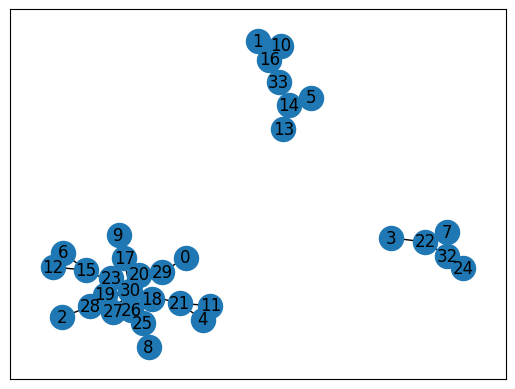

In [8]:
class GraphVisualization:

    def __init__(self):
        self.visual = []
        self.nodes = []

    def addEdge(self, a, b, d):
        temp = [a, b, {"dist": d}]
        self.visual.append(temp)

    def addNode(self, a):
        self.nodes.append(a)

    def visualize(self):
        gg = nx.Graph()
        gg.add_nodes_from(self.nodes)
        gg.add_edges_from(self.visual)
        nx.draw_networkx(gg)
        plt.show()

G = GraphVisualization()
# for i, _ in enumerate(frame_graphs[0].nodes):
#     G.addNode(i)
for i, adj in enumerate(frame_graphs[0].adjacency_list):
    G.addEdge(adj[0], adj[1], frame_graphs[0].edges[i])

G.visualize()

34


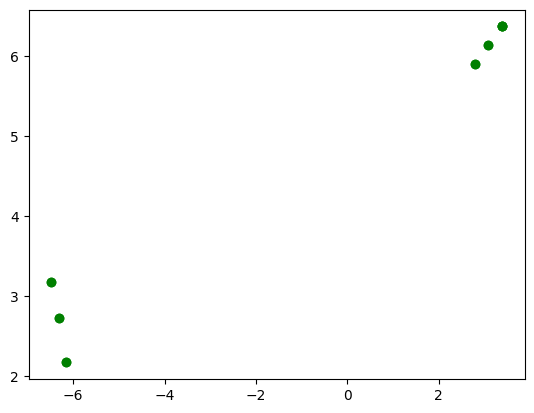

In [9]:

tiny_array = [t.to_numpy() for t in sorted_data]
print(len(tiny_array[0])+len(tiny_array[1])+len(tiny_array[2]))

# plt.scatter(tiny_array[0][:, 5], tiny_array[0][:, 4], c='blue')
# plt.scatter(tiny_array[1][:, 5], tiny_array[1][:, 4], c='red')
plt.scatter(tiny_array[2][:, 5], tiny_array[2][:, 4], c='green')
# plt.xlim(-10, 4)
# plt.ylim(2, 14)
plt.show()

In [10]:
class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, split='train', transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        if split == 'train':
            path = self.processed_paths[0]
        elif split == 'validation':
            path = self.processed_paths[1]
        else:
            path = self.processed_paths[2]
        self.load(path)

    @property
    def raw_file_names(self):
        return ['ply_data_train.h5', 'ply_data_validation.h5', 'ply_data_test.h5']

    @property
    def processed_file_names(self):
        return ['ply_data_train.pt', 'ply_data_validation.pt', 'ply_data_test.pt']

    def download(self):
        pass

    def process(self):
        # Read data into huge `Data` list.
        data_list = [...]

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.save(data_list, self.processed_paths[0])
        # For PyG<2.4:
        # torch.save(self.collate(data_list), self.processed_paths[0])

In [116]:
data_collection = [Data(x=torch.tensor(np.array(graph.nodes), dtype=torch.float), 
                        edge_index=torch.tensor(np.array(graph.adjacency_list), dtype=torch.int64).t().contiguous(),
                        edge_attr=torch.tensor(np.array(graph.edges), dtype=torch.float),
                        y=torch.tensor(graph.label, dtype=torch.long)) 
                   for graph in frame_graphs]
# data_collection = torch.tensor(dataset)
random.shuffle(data_collection)
train = data_collection[:int(0.7 * len(data_collection))]
test = data_collection[int(0.7 * len(data_collection)):int(0.85 * len(data_collection))]
val = data_collection[int(0.85 * len(data_collection)):]
# train, test, val = np.split(data_collection, [int(0.7 * len(data_collection)), int(0.85 * len(data_collection))], axis=0)
# dataset = np.asarray(data_collection, dtype="object")

# my_dataset = TensorDataset(torch.tensor(data_collection)) 
train_dataloader = DataLoader(train[:1000], batch_size=32, shuffle=True) 
test_dataloader = DataLoader(train[:300], batch_size=32, shuffle=True) 

C:\Users\bakos\AppData\Local\Temp\ipykernel_19760\3660649287.py:4: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y=torch.tensor(graph.label, dtype=torch.long))


In [117]:
class GCN(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.conv1 = GCNConv(in_features, 16)
        self.conv2 = GCNConv(16, out_features)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        edge_weight = data.edge_attr
        
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        x = scatter(x, data.batch, dim=0, reduce='mean')
        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(4,6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
losses = []
for epoch in range(500):
    for data_batch in train_dataloader:
        data_batch = data_batch.to(device)
        optimizer.zero_grad()
        out = model(data_batch)
        loss = F.nll_loss(out, data_batch.y)
        losses.append(loss)
        loss.backward()
        optimizer.step()

In [118]:
model.eval()
total_y_pred_label = []
total_y_true_label = []
correct = 0
for test_batch in test_dataloader:
    pred = model(test_batch).argmax(dim=1)
    total_y_pred_label.extend(pred)
    total_y_true_label.extend(test_batch.y)
    # print("Predicted: " + str(pred) + ", real: "+ str(test_batch.y))
    correct += (pred == test_batch.y).sum()
acc = int(correct) / 300
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.4100


In [122]:
SHAPE_NAMES = ["0","1","2","3","4","5"]
total_y_pred = [pred_label.item() for pred_label in total_y_pred_label]
total_y_true = [true_label.item() for true_label in total_y_true_label]
cm = confusion_matrix(total_y_true, total_y_pred)
print(cm)
# cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

df_cm = pd.DataFrame(cm, index = SHAPE_NAMES,
              columns = SHAPE_NAMES)
plt.figure(figsize = (10,7))
plot = sn.heatmap(df_cm, annot=True, cmap='Blues')
figure = plot.get_figure()
plt.ylabel('True Label')
plt.xlabel('Predicated Label')

[[34 15 10  3  3]
 [23 32 12  2  6]
 [10 19 24  0  4]
 [ 6 21  7  3 10]
 [ 2 20  4  0 30]]


ValueError: Shape of passed values is (5, 5), indices imply (6, 6)